# Dynamic programming

## This notebook is for presenting the results for our exam - "What Are The Effects of Sweden’s Pension System on Retirement Behaviour?"

Created by **Matias Bjørn Frydensberg Hall (PKT593)** and **Thomas Theodor Kjølbye (XTB358)**

In [3]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import math
import time
from scipy import interpolate
from scipy import optimize

import os
import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to exam
import ver5 as karl5
import ver6 as karl6
import estimate as est

# Model 5 with all states except pension age

## Estimation

In [29]:
# Estimation
model5 = karl5.karlstrom()
data5 = est.read_data(model5, ver =1)
#Different initial guesses

theta_hat, loglik, model_new = est.estimate(model=model5,data=data5,theta0=[0.3424,-2.0450,0.7610,65.4905,0.0070])
# These guesses have also been run
#theta_hat, loglik, model_new = est.estimate(model=model5,data=data5,theta0=[0.8,0.8,0.35,65,0.007])
#theta_hat, model_new = est.estimate(model=model5,data=data5,theta0=[0,0,0,0,0])
#theta_hat, loglik, model_new = est.estimate(model=model5,data=data5,theta0=theta_hat)

0.3424    -2.0450    0.7610    65.4905        0.0070


C:\Users\matia\Google Drive\Skole\Dynamic programming\DynamicProgramming\ver5.py:146: RuntimeWarning: overflow encountered in exp
  ((np.exp((t-self.theta[3])/self.theta[4]))/(1+np.exp((t-self.theta[3])/self.theta[4])))
C:\Users\matia\Google Drive\Skole\Dynamic programming\DynamicProgramming\ver5.py:146: RuntimeWarning: invalid value encountered in double_scalars
  ((np.exp((t-self.theta[3])/self.theta[4]))/(1+np.exp((t-self.theta[3])/self.theta[4])))


model solved in 4.1692070960998535 seconds
-0.0685880318386716
0.3424    -2.0450    0.7610    65.4905        0.0070
model solved in 4.360118865966797 seconds
-0.06858803176533611
0.3424    -2.0450    0.7610    65.4905        0.0070
model solved in 4.323120355606079 seconds
-0.06858803184168351
0.3424    -2.0450    0.7610    65.4905        0.0070
model solved in 4.342399597167969 seconds
-0.06858803184452117
0.3424    -2.0450    0.7610    65.4905        0.0070
model solved in 4.294703960418701 seconds
-0.0685880318386716
0.3424    -2.0450    0.7610    65.4905        0.0070
model solved in 4.156529664993286 seconds
-0.0685880318386716
0.3473    -2.0452    0.7606    65.4905        0.0070
model solved in 4.2685019969940186 seconds
-0.0685675045973317
0.3473    -2.0452    0.7606    65.4905        0.0070
model solved in 4.152555227279663 seconds
-0.06856750454715531
0.3473    -2.0452    0.7606    65.4905        0.0070
model solved in 4.324458360671997 seconds
-0.06856750459922645
0.3473    -

KeyboardInterrupt: 

## Estimated model(ver 5)

In [4]:
# Create model with our estimates, solve it and read data

import ver5 as karl5
model5_new = karl5.karlstrom()
sol5_new = model5_new.bellman()
model5_new.theta = [0.3424,-2.0450,0.7610,65.4905,0.0070]

data5_new = est.read_data(model5_new,ver=1)

# Unpack data

age = data5_new.age_index
w = data5_new.w_index
ap = data5_new.ap_index
m = data5_new.married
d = data5_new.ret

# Create ccp's for data
data5_new["ccp"] = sol5_new.ccp[age,w,ap,m]

C:\Users\matia\Google Drive\Skole\Dynamic programming\DynamicProgramming\ver5.py:146: RuntimeWarning: overflow encountered in exp
  ((np.exp((t-self.theta[3])/self.theta[4]))/(1+np.exp((t-self.theta[3])/self.theta[4])))
C:\Users\matia\Google Drive\Skole\Dynamic programming\DynamicProgramming\ver5.py:146: RuntimeWarning: invalid value encountered in double_scalars
  ((np.exp((t-self.theta[3])/self.theta[4]))/(1+np.exp((t-self.theta[3])/self.theta[4])))


model solved in 4.083770275115967 seconds


### Hazard rates

In [5]:
pr = np.zeros(np.size(model5_new.t_grid))
for t in range (np.size(model5_new.t_grid)):
    pr[t] = np.mean(data5_new[data5_new["age_index"]==t].ccp)
    
    

hazard = 1-pr[10:21]
sum_hazard = np.sum(hazard)
age = [60,61,62,63,64,65,66,67,68,69,70]

Eretire = np.sum(hazard*age)/sum_hazard

print(hazard,'\n\n',Eretire)


[0.         0.1126599  0.17144466 0.25833225 0.38245209 0.54651774
 0.75829584 0.77304699 0.81577935 0.85051187 1.        ] 

 66.99146307260425


### CCP plots

In [11]:
# CCP for sample (Hazard rates)
file_directory = os.getcwd() + '\\Data\\' + 'sparadata.xls' 
data = pd.read_excel(file_directory, skipfooter = 3) # Remove last 3 rows that are NA 

data["work"] = 1 - data.ret # = 1 if working, = 0 if retired
working = data.groupby(["age"])["work"].sum()
retiring = data.groupby(["age"])["ret"].sum()
hazard_rates = retiring / (working + retiring)
CCP_sample = np.ones(np.shape(hazard_rates)) - hazard_rates
CCP_sample = CCP_sample[8:] # get correct age
CCP_s =np.cumprod(CCP_sample) # Share of population working at given age

In [12]:
# Fitted on data

# Create array for ccp age averages
pr = np.zeros(np.size(model5_new.t_grid))

# Loop over ages computing averages
for t in range (np.size(model5_new.t_grid)):
    pr[t] = np.mean(data5_new[data5_new["age_index"]==t].ccp)

# Get cumulative product of age averages
ccp_data = np.cumprod(pr[8:21])



In [32]:
# Matched on moments
y = np.zeros(np.size(model5_new.t_grid))

for it, t in enumerate(model5_new.t_grid):
    y[it] = np.mean(sol5_new.ccp[it,11,6,1])
    
ccp_moment = np.cumprod(y[8:21])

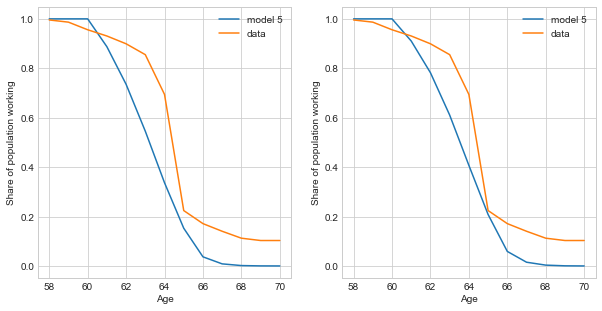

In [19]:
# Plot them in one graph

# Plot on data
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(model5_new.t_grid[8:21],ccp_data, label='model 5')
ax[0].plot(model5_new.t_grid[8:21], CCP_s, label='data')

ax[0].set_ylabel('Share of population working')
ax[0].set_xlabel('Age')
ax[0].legend(frameon=False)

#plot on moments
ax[1].plot(model5_new.t_grid[8:21],ccp_moment, label='model 5')
ax[1].plot(model5_new.t_grid[8:21], CCP_s, label = 'data')

ax[1].set_ylabel('Share of population working')
ax[1].set_xlabel('Age')

ax[1].legend(frameon=False)

fig.savefig(os.getcwd() + '\Figures\ccp5.png')

# Model 6 with all state variables

In [94]:
# Estimation
#model6 = karl6.karlstrom()
#data6 = est.read_data(model6, ver =6)
#theta_hat, loglik, model_new = est.estimate(model=model6,data=data6,theta0=[0.8,0.8,0.35,65,0.007],ver=6)

0.8000    0.8000    0.3500    65.0000        0.0070


C:\Users\matia\Google Drive\Skole\Dynamic programming\DynamicProgramming\ver6.py:138: RuntimeWarning: overflow encountered in exp
  ((np.exp((t-self.theta[3])/self.theta[4]))/(1+np.exp((t-self.theta[3])/self.theta[4])))
C:\Users\matia\Google Drive\Skole\Dynamic programming\DynamicProgramming\ver6.py:138: RuntimeWarning: invalid value encountered in double_scalars
  ((np.exp((t-self.theta[3])/self.theta[4]))/(1+np.exp((t-self.theta[3])/self.theta[4])))


model solved in 34.2627489566803 seconds


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [22]:
# Setup model, solution and data
import ver6 as karl6
model6 = karl6.karlstrom()
sol6 = model6.bellman()
model6.theta = [0.3424,-2.0450,0.7610,65.4905,0.0070]
data6 = est.read_data(model6, ver =6)


model solved in 35.11057114601135 seconds


In [28]:
# Hazard

data6 = est.read_data(model6, ver=6)

age = data6.age_index
w = data6.w_index
ra = data6.ret_age
ra = ra.astype(int)
data6["i_ra"] = ra-60
ira = data6.i_ra
ira = ira.astype(int)
ap = data6.ap_index
m = data6.married

data6["ccp"] = sol6.ccp[age,w,ap,m,ira]


pr = np.zeros(np.size(model6.t_grid))
for t in range (np.size(model6.t_grid)):
    pr[t] = np.mean(data6[data6["age_index"]==t].ccp)
    
    


hazard = 1-pr[10:21]
hazard[-1] = 1
sum_hazard = np.sum(hazard)
age = [60,61,62,63,64,65,66,67,68,69,70]

Eretire = np.sum(hazard*age)/sum_hazard

print(hazard,'\n\n',Eretire)

[0.13834409 0.20064779 0.33083276 0.40426432 0.45456213 0.61537124
 0.78598655 0.81751246 0.52991317 1.         1.        ] 

 66.47526036235556


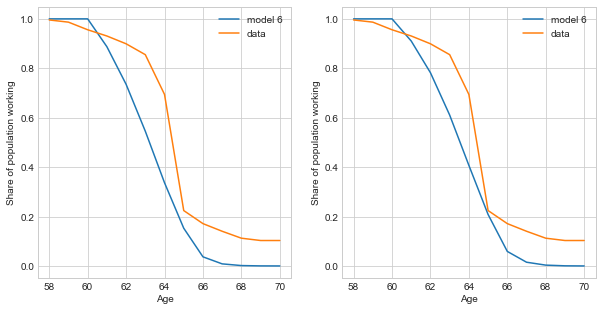

In [24]:
# Fitted on data

# Create array for ccp age averages
pr = np.zeros(np.size(model5_new.t_grid))

# Loop over ages computing averages
for t in range (np.size(model5_new.t_grid)):
    pr[t] = np.mean(data5_new[data5_new["age_index"]==t].ccp)

# Get cumulative product of age averages
ccp6_data = np.cumprod(pr[8:21])


# Matched on moments
y = np.zeros(np.size(model5_new.t_grid))

for it, t in enumerate(model5_new.t_grid):
    y[it] = np.mean(sol5_new.ccp[it,11,6,1])
    
ccp6_moment = np.cumprod(y[8:21])


# Plot of CCP

# Plot on data
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(model6.t_grid[8:21],ccp6_data, label='model 6')
ax[0].plot(model6.t_grid[8:21], CCP_s, label='data')

ax[0].set_ylabel('Share of population working')
ax[0].set_xlabel('Age')
ax[0].legend(frameon=False)

#plot on moments
ax[1].plot(model6.t_grid[8:21],ccp6_moment, label='model 6')
ax[1].plot(model6.t_grid[8:21], CCP_s, label = 'data')

ax[1].set_ylabel('Share of population working')
ax[1].set_xlabel('Age')

ax[1].legend(frameon=False)

fig.savefig(os.getcwd() + '\Figures\ccp6.png')